In [74]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [75]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Create a straight line dataset using the linear regression formula (a * X + c).

In [76]:
a = 0.3
c = 0.9

In [77]:
x_points = torch.arange(0,1,0.005).unsqueeze(dim=1)
y_points = torch.tensor([x * a + c for x in x_points]).unsqueeze(dim=1)

In [78]:
def test_train_split(x_data, y_data, train_share):
    train_lines = int(len(x_data) * train_share)
    return x_data[:train_lines], x_data[train_lines:], y_data[:train_lines], y_data[train_lines:]

In [79]:
X_train, X_test, y_train, y_test  = test_train_split(x_points, y_points, 0.8)

In [80]:
len(X_train), len(y_train), len(X_test), len(y_test)

(160, 160, 40, 40)

In [81]:
X_train[:10], y_train[:10]

(tensor([[0.0000],
         [0.0050],
         [0.0100],
         [0.0150],
         [0.0200],
         [0.0250],
         [0.0300],
         [0.0350],
         [0.0400],
         [0.0450]]),
 tensor([[0.9000],
         [0.9015],
         [0.9030],
         [0.9045],
         [0.9060],
         [0.9075],
         [0.9090],
         [0.9105],
         [0.9120],
         [0.9135]]))

In [82]:
def plot_train_test_predicted(x_train, x_test, y_train, y_test, predicted = None):
    plt.figure(figsize=(8, 5))
    plt.scatter(x=x_train, y=y_train, c='b', s=4, label='train_data')
    plt.scatter(x=x_test, y=y_test, c='y', s=4, label='test_data')
    if predicted is not None:
        plt.scatter(x=x_test, y=predicted, c='black',s=4, label='predicted_data')
    plt.legend();
    

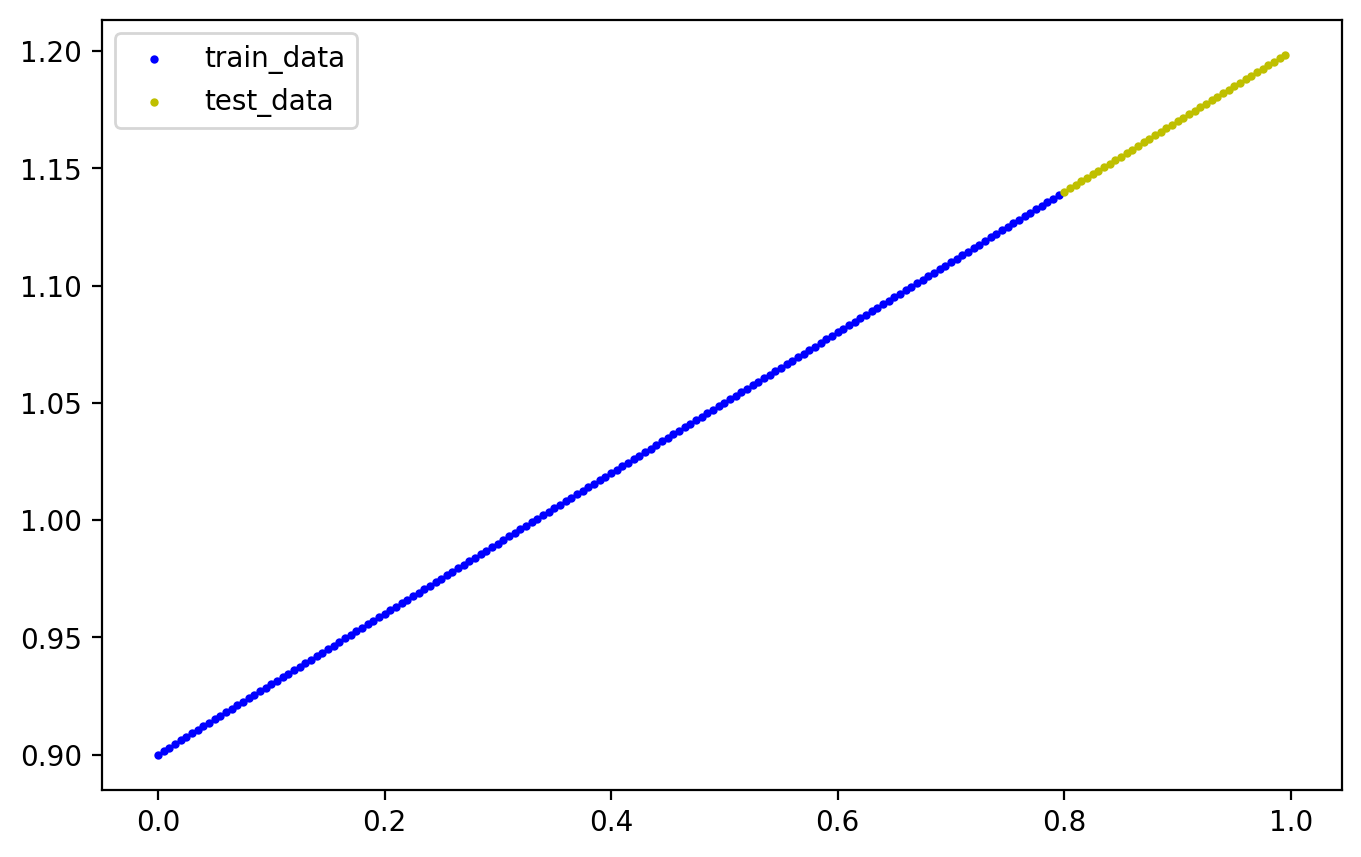

In [83]:
plot_train_test_predicted(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test)

## 2. Build a PyTorch model by subclassing nn.Module.

In [84]:
# my linear regression is like y = a(bi) + c

In [85]:
class MyLinearRegression(nn.Module):

    def __init__(self):

        super().__init__()

        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)


    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # y = a(bi) + c
        return self.weight * x + self.bias
        

In [86]:
torch.manual_seed(42)

my_model_1 = MyLinearRegression()
list(my_model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [87]:
my_model_1.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [88]:
with torch.inference_mode():
    prediction_1 = my_model_1.forward(X_test)

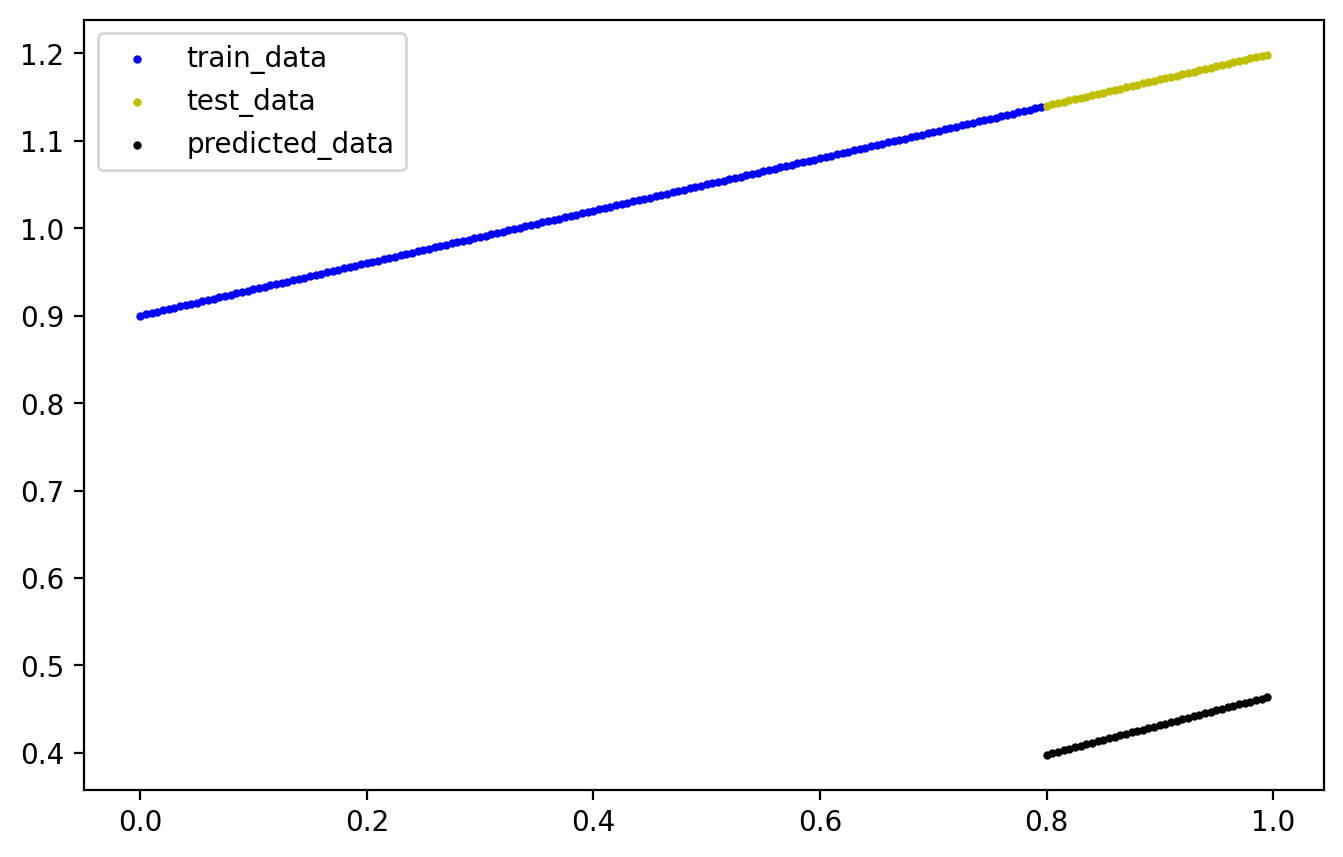

In [89]:
plot_train_test_predicted(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test, predicted=prediction_1)

## 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

In [90]:
l1_loss = nn.L1Loss()
optimizer = torch.optim.SGD(params=my_model_1.parameters(), lr=0.01)

In [91]:
def train_model(model, 
                loss_func,
                optimizer,
                x_train,
                y_train, 
                x_test,
                y_test,
                num_epoches,
                inference_mode_interval):

    torch.manual_seed(42)
    train_loss_values = []
    test_loss_values = []
    epoch_count = []

    for num_epoch in range(1, num_epoches+1):

        # Put model in training mode(this is default state of a model)
        model.train()

        # 1. Forward pass on train data using the forward() method inside
        y_pred_train = model(X_train)    

        # 2. Calculate the loss for train values
        train_loss = loss_func(y_pred_train, y_train)

        # 3. Zero gradients of the optimizer(they accumulete by default)
        optimizer.zero_grad()

        # 4. Perform backpropagation on the loss, a.k. the computation of step value for each parameter, using the back propagation
        train_loss.backward()

        # 5. Progress/step the optimizer (gradient descent)
        optimizer.step()

        model.eval()
            
        with torch.inference_mode():
            
            y_pred_test = model(X_test)
            test_loss = loss_func(y_pred_test, y_test)

            if num_epoch % inference_mode_interval == 0:

                test_loss = loss_func(y_pred_test, y_test)
    
                test_loss_values.append(float(test_loss))
                train_loss_values.append(float(train_loss))
                epoch_count.append(num_epoch)
                
                print(f'epoch number: {num_epoch} | train_loss: {train_loss} | test_loss: {test_loss}')

    return train_loss_values ,test_loss_values, epoch_count

In [92]:
my_model_1_train_loss, my_model_1_test_loss, epoch_count = train_model(model = my_model_1, 
                                                                       loss_func=l1_loss,
                                                                       optimizer=optimizer,
                                                                       x_train=X_train,
                                                                       y_train=y_train,
                                                                       x_test=X_test,
                                                                       y_test=y_test,
                                                                       num_epoches=300,
                                                                       inference_mode_interval=20)          

epoch number: 20 | train_loss: 0.5365849137306213 | test_loss: 0.4669097065925598
epoch number: 40 | train_loss: 0.30498379468917847 | test_loss: 0.19555850327014923
epoch number: 60 | train_loss: 0.0813402459025383 | test_loss: 0.06636635959148407
epoch number: 80 | train_loss: 0.053131140768527985 | test_loss: 0.1164325699210167
epoch number: 100 | train_loss: 0.0460939034819603 | test_loss: 0.10647034645080566
epoch number: 120 | train_loss: 0.03925246745347977 | test_loss: 0.09112371504306793
epoch number: 140 | train_loss: 0.03241180628538132 | test_loss: 0.07543172687292099
epoch number: 160 | train_loss: 0.02557225152850151 | test_loss: 0.05922167748212814
epoch number: 180 | train_loss: 0.018732449039816856 | test_loss: 0.0431843139231205
epoch number: 200 | train_loss: 0.011892767623066902 | test_loss: 0.02706059440970421
epoch number: 220 | train_loss: 0.005052905064076185 | test_loss: 0.011023235507309437
epoch number: 240 | train_loss: 0.006118144374340773 | test_loss: 0.00

In [100]:
def plot_train_test_loss(epoches, train_loss, test_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, train_loss, c='g', label='train_loss')
    plt.plot(epoches, test_loss, c='r', label='test_loss')
    plt.legend()
    plt.show;

In [101]:
epoch_count

[20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

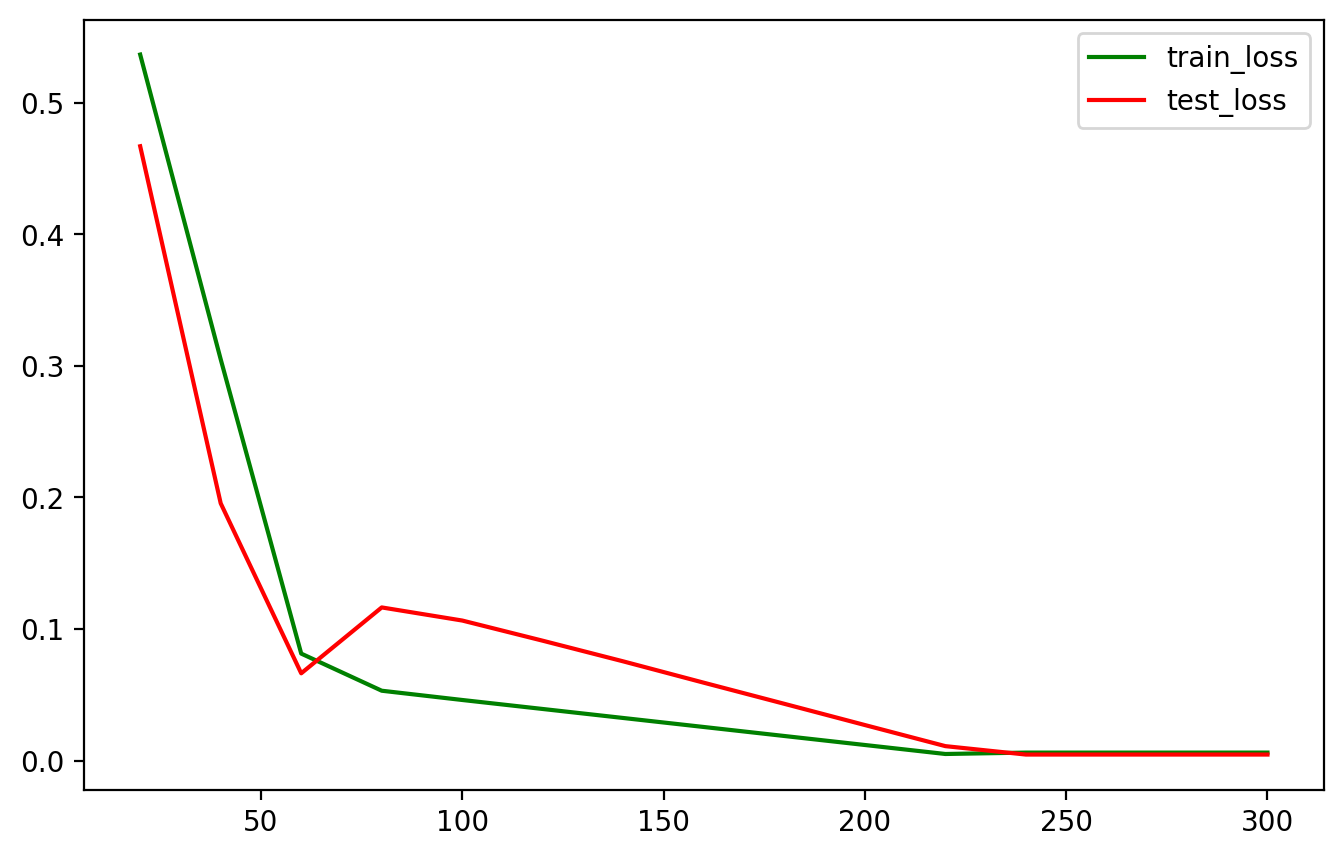

In [102]:
plot_train_test_loss(epoches=epoch_count,train_loss=my_model_1_train_loss,test_loss=my_model_1_test_loss)

In [103]:
with torch.inference_mode():
    prediction_2 = my_model_1.forward(X_test)

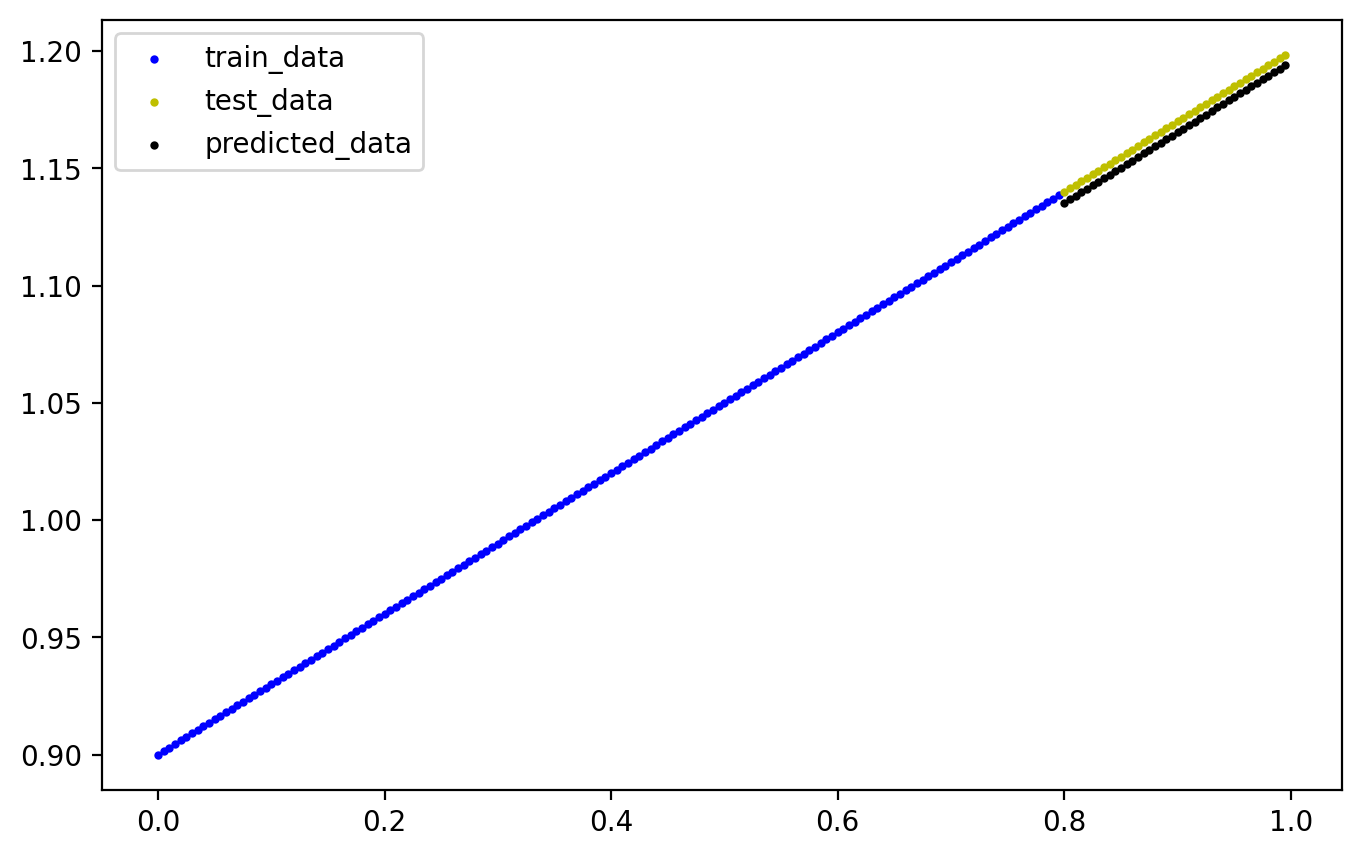

In [104]:
plot_train_test_predicted(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test, predicted=prediction_2)

In [105]:
my_model_1.state_dict()

OrderedDict([('weight', tensor([0.3017])), ('bias', tensor([0.8939]))])

## Save and download model

In [117]:
from pathlib import Path
import os

In [140]:
def save_model_to_dir(model, model_name, save_dir='models'):
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
        
    curr_time = datetime.now().strftime("%H:%M:%S_%m-%d-%Y")
    torch.save(obj=model.state_dict(), f = f'{save_dir}/{model_name}_{curr_time}')

In [177]:
def load_model(loaded_model_class, model_name, model_dir = 'models'):

    loaded_model = loaded_model_class()
    loaded_model.load_state_dict(torch.load(f'{model_dir}/{model_name}'))
    return loaded_model
    

In [178]:
loaded_my_model_1 = load_model(loaded_model_class=MyLinearRegression,
                               model_name='my_home_train_linear_regression_16:27:15_11-10-2023')

In [182]:
with torch.inference_mode():
    prediction_3 = loaded_my_model_1 .forward(X_test)

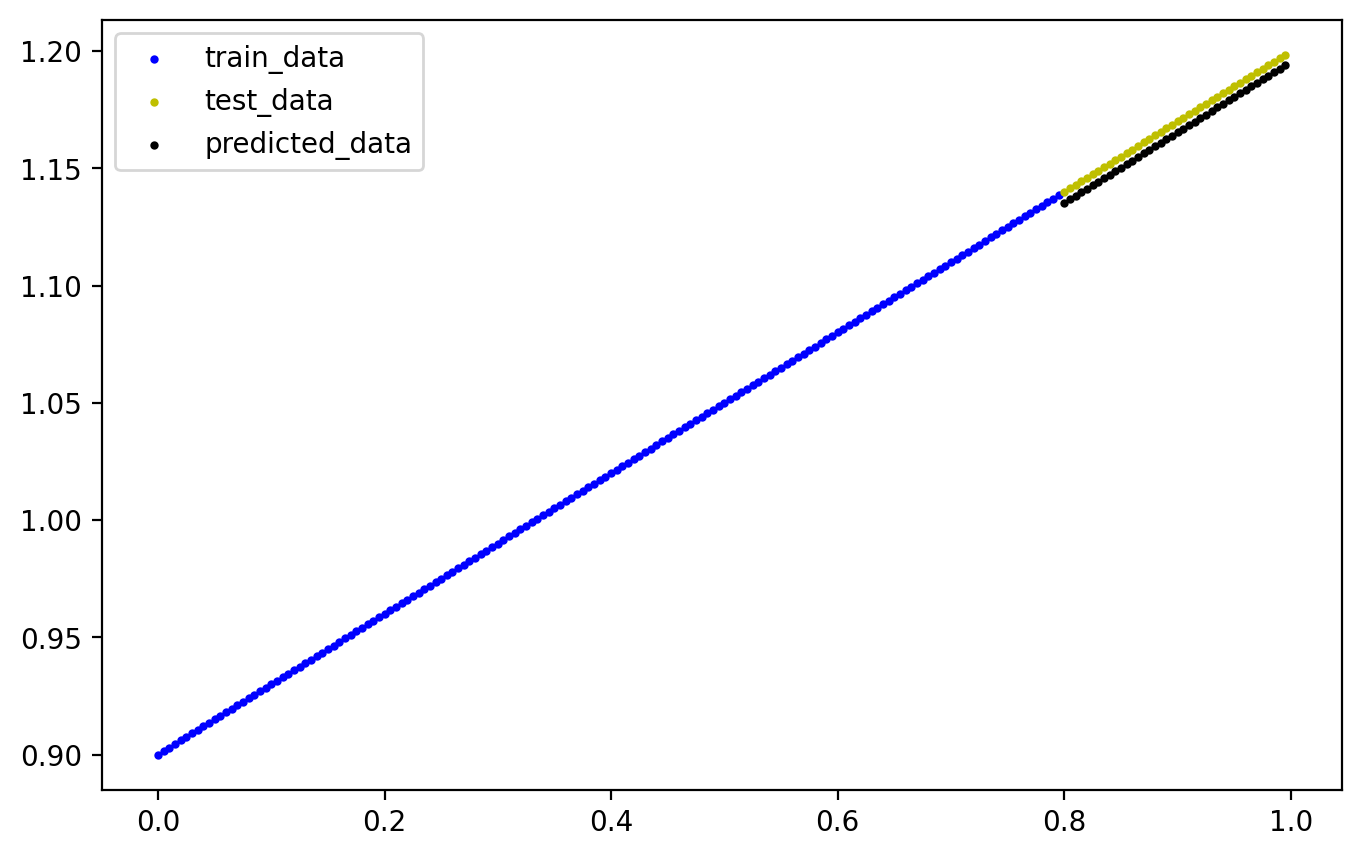

In [183]:
plot_train_test_predicted(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test, predicted=prediction_3)